In [13]:
from sklearn.datasets import load_boston
boston = load_boston()

The boston variable itself is a dictionary, so you can check for its keys using the .keys() method.

In [14]:
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [15]:
print(boston.data.shape)

(506, 13)


As you can see it returned (506, 13), that means there are 506 rows of data with 13 columns. 

In [16]:
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [17]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Now let’s convert it into a pandas DataFrame!

In [18]:
import pandas as pd

data = pd.DataFrame(boston.data)
data.columns = boston.feature_names

In [19]:
#Explore top 5 rows in the dataset
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Append boston.target to your pandas DataFrame as PRICE

In [20]:
data['PRICE'] = boston.target

If you plan to use XGBoost on a dataset which has categorical features you may want to consider applying some encoding (like one-hot encoding) to such features before training the model. Also, if you have some missing values such as NA in the dataset you may or may not do a separate treatment for them, because XGBoost is capable of handling missing values internally. You can check out this link if you wish to know more on this. You will build the model using Trees as base learners (which are the default base learners) using XGBoost's scikit-learn compatible API. Along the way, you will also learn some of the common tuning parameters which XGBoost provides in order to improve the model's performance, and using the root mean squared error (RMSE) performance metric to check the performance of the trained model on the test set. Root mean Squared error is the square root of the mean of the squared differences between the actual and the predicted values. As usual, you start by importing the library xgboost and other important libraries that you will be using for building the model.

In [21]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
PRICE      506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


In [23]:
X, y = data.iloc[:,:-1],data.iloc[:,-1]

In [24]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

# XGBoost's hyperparameters

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [28]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)


In [29]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [30]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 10.397587


In [32]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)


In [33]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,21.680255,0.025604,21.719119,0.019027
1,19.740498,0.072069,19.818879,0.061769
2,18.007202,0.119743,18.109863,0.129374
3,16.463924,0.115088,16.587236,0.182337
4,14.990312,0.112000,15.132977,0.166282


In [34]:
print((cv_results["test-rmse-mean"]).tail(1))


49    3.862102
Name: test-rmse-mean, dtype: float64


# Visualize Boosting Trees and Feature Importance


In [35]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)


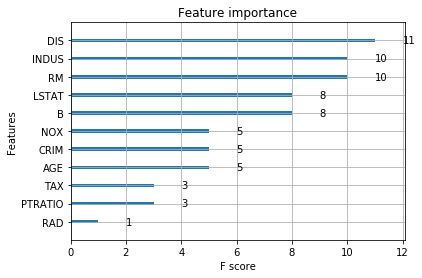

In [39]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()